# Sistemas de Big Data - Tarea 7


## Apartado 3: detección de outliers, combinaciones y consultas de dataframes

Descarga el archivo con el resumen de los alojamientos: listings.csv (o una copia en el repositorio del curso).
Nos vamos a centrar en el precio por noche (columna price). Ya vimos que esta columna presenta una serie de outliers que distorsionan todas las estadísticas.

### 3.1. Muestra el diagrama de caja (boxplot) del precio por noche.

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,44085,Villa in Addaia great sea view and fun pool,193043,Manuela,NaN,Es Mercadal,40.00974,4.19958,Entire home/apt,460.0,5,21,2024-08-25,0.14,3,0,1,ET3036ME
1,102558,appartment in Menorca -Cala Galdana,536023,Yolanda,NaN,Ciutadella de Menorca,39.94340,3.96130,Entire home/apt,121.0,3,67,2024-10-29,0.41,1,343,9,ET2253ME
2,294398,Son Esquella - Charming Menorca,312145,Sol,NaN,Alaior,39.89082,4.11595,Entire home/apt,NaN,32,11,2019-09-08,0.10,3,0,0,NaN
3,295705,The Most Perfect Villa in Menorca!,312145,Sol,NaN,Alaior,39.89028,4.11476,Entire home/apt,NaN,32,24,2022-05-30,0.16,3,0,0,NaN
4,357026,Coqueto apartamento Son Bou Menorca + Rent our...,1740878,Emilio,NaN,Alaior,39.90520,4.07072,Entire home/apt,75.0,5,83,2024-11-03,0.55,1,288,16,Licencia San Jaume Zona 5 APM-1880


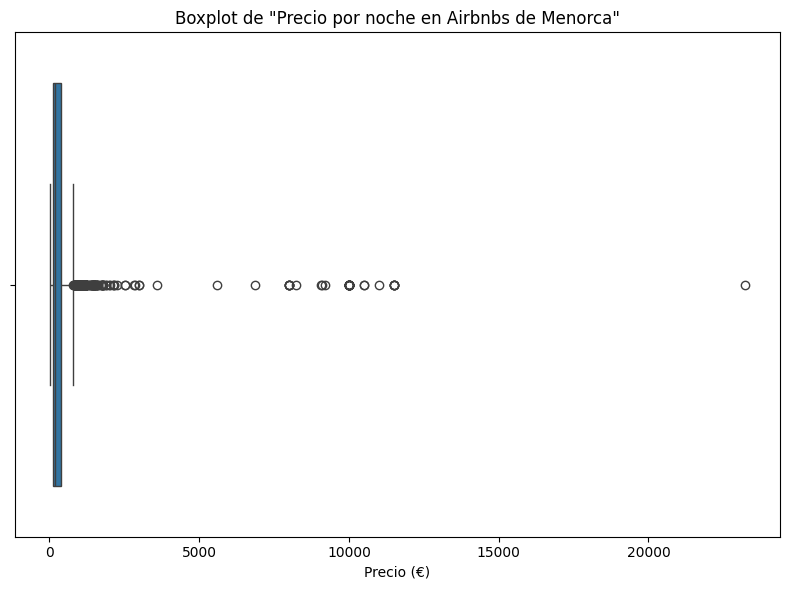

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot de "Precio por noche en Airbnbs de Menorca"')
plt.xlabel('Precio (€)')
plt.tight_layout()
plt.show()

### 3.2. Calcula el precio medio y su mediana. Detecta los outliers y sustituye sus valores por el precio medio que has calculado. Consideraremos outlier aquel que se aleje de la media más de 2 veces la desviación estándar. A continuación, calcula de nuevo la media y la mediana. Comenta si han cambiado y, en caso afirmativo, cómo.

In [31]:
# Calculamos el precio medio, su mediana y la desviación estándar con outliers.
mean_price = df['price'].mean()
median_price = df['price'].median()
std_price = df['price'].std()

# Encontramos los outliers y los reemplazamos por los valores calculados antes
df_no_outliers = df.copy()
outlier_condition = (df['price'] < mean_price - 2 * std_price) | (df['price'] > mean_price + 2 * std_price)
df_no_outliers.loc[outlier_condition, 'price'] = mean_price

# Volvemos a calcular la media y mediana sin outliers
no_outliers_mean_price = df_no_outliers['price'].mean()
no_outliers_median_price = df_no_outliers['price'].median()

# Mostramos los resultados
print(f'- Media: {mean_price:.2f}€  --->  {no_outliers_mean_price:.2f}€')
print(f'- Mediana: {median_price:.2f}  --->  {no_outliers_median_price:.2f}€')
print(f'- Desviación estándar: {std_price:.2f}€')

- Media: 436.14€  --->  305.37€
- Mediana: 192.00  --->  192.00€
- Desviación estándar: 1188.81€


Después de sustituir los outliers por el precio medio:
- La media ha bajado notablemente (de 436,14 € a 305,37 €), lo cual era esperable porque los valores extremos inflaban la media calculada al principio.

- La mediana se ha mantenido igual (192,00 €), ya que no se ve afectada por los valores extremos de la misma forma que la media.

Esto nos ayuda a confirmar que la media es sensible a los outliers, mientras que la mediana no se ve tan afectada.

### 3.3. Calcula el precio medio (una vez sustituidos los outliers) por noche de cada uno de los municipios de la isla y ordénalos de más caro a más barato.


In [73]:
# Calculamos el precio medio por municipio después de limpiar los outliers
avg_price_by_area = df_no_outliers.groupby('neighbourhood')['price'].mean()

# Ordenamos los municipios de más caro a más barato
sorted_avg_price_by_area = avg_price_by_area.sort_values(ascending=False)

# Mostramos el resultado
print('Precio medio por municipio')
print('-' * 30)
print(sorted_avg_price_by_area)

Precio medio por municipio
------------------------------
neighbourhood
Es Migjorn Gran          489.257046
Ferreries                403.790431
Sant Lluís               398.284436
Mahón                    358.397254
Alaior                   298.709857
Ciutadella de Menorca    271.465242
Es Mercadal              269.029271
Es Castell               207.100000
Name: price, dtype: float64


Ahora también trabajaremos con el archivo detallado de comentarios: reviews.csv.gz

### 3.4. Indica cuáles son los 10 usuarios (reviewer_id) que han escrito más comentarios en alojamientos que tienen licencia (columna license), ordenados de mayor a menor número de comentarios.

In [76]:
reviews_data = pd.read_csv('https://github.com/tnavarrete-iedib/bigdata-24-25/raw/refs/heads/main/reviews.csv.gz')
listings_data = df.copy()

# Combinamos los comentarios con la información de las licencias
merged_reviews_data = reviews_data.merge(listings_data[['id', 'license']], left_on='listing_id', right_on='id')
licensed_reviews_data = merged_reviews_data[merged_reviews_data['license'].notna()]

# Agrupamos por revisor y contar el número de comentarios
reviewer_comment_count = licensed_reviews_data.groupby('reviewer_id').size().reset_index(name='comment_count')
sorted_reviewers = reviewer_comment_count.sort_values(by='comment_count', ascending=False).head(10)

# Mostramos los 10 primeros revisores con un formato más claro
print(f'{"Licencia":<15} {"ID del revisor":<15} {"Recuento de comentarios":<15}')
print('-' * 65)

for index, row in sorted_reviewers.iterrows():
    reviewer_id = row['reviewer_id']
    comment_count = row['comment_count']

    # Obtenemos la información de la licencia
    license_info = licensed_reviews_data[licensed_reviews_data['reviewer_id'] == reviewer_id]['license'].iloc[0]

    # Mostramos los resultados
    print(f'{license_info:<15} {reviewer_id:<15} {comment_count:<15}')

Licencia        ID del revisor  Recuento de comentarios
-----------------------------------------------------------------
ET1387ME        282037351       6              
ET1412ME        194712546       6              
ET2253ME        48504022        6              
ET3382ME        75137674        5              
ET 1237 ME      82820857        5              
116/1989        408763892       5              
ET38ME          5952665         5              
ET1458ME        394948661       5              
VTV391ME        265749973       5              
ET0191ME        252193730       4              


### 3.5. Calcula cuántos comentarios hay de cada municipio de la isla (no puedes usar la columna number_of_reviews del archivo listings, tienes que calcularlo a partir de los datos del archivo reviews). Ordénalos en orden decreciente por número de comentarios.

In [75]:
# Merge reviews with listings to include neighbourhood column
merged_data = reviews_data.merge(listings_data[['id', 'neighbourhood']], left_on='listing_id', right_on='id')

# Count and sort
comments_by_area = merged_data.groupby('neighbourhood').size().reset_index(name='comment_count')
sorted_comments = comments_by_area.sort_values(by='comment_count', ascending=False)

print('Número de comentarios por municipio:')
print('-' * 40)
for index, row in sorted_comments.iterrows():
    print(f'{row["neighbourhood"]:<21} -------> {row["comment_count"]:<21}')

Número de comentarios por municipio:
----------------------------------------
Ciutadella de Menorca -------> 32756                
Alaior                -------> 12446                
Es Mercadal           -------> 11876                
Sant Lluís            -------> 9441                 
Mahón                 -------> 2990                 
Ferreries             -------> 2057                 
Es Migjorn Gran       -------> 729                  
Es Castell            -------> 717                  
